Alexander W. Criswell 7/16/25

The idea here to implement the most bare-bones implementation of the formalism we developed at the Sprint, ignoring all realistic aspects, just so we can get the paper out without spinning our wheels on some of the finer details of Global Fit implementation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax; jax.config.update("jax_enable_x64", True)
import scipy.stats as st
from corner import corner
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial
plt.style.use('default')

In [4]:
# ## make a small fake pop
# mc_dist = st.norm(0.6,0.2)
# fgw_dst = st.powerlaw(loc=1e-5,scale=0.01)
# plt.figure()
# x = np.linspace(0,0.01)
# plt.plot(x,st.powerlaw.pdf(x,3,loc=1e-5,scale=0.01))
# plt.show()

In [5]:
class HierarchicalPrior:
    
    '''
    Generic class to handle the population-informed priors.
    
    Arguments
    -------------
    prior_dict (dict) : Dictionary of priors given as {'parameter_name':prior_function,...}
    conditional_map (func) : Function which returns the population-dependent priors given in prior_dict
                             conditioned on the current values of the population parameters given as pop_theta
    kwargs : Any additional values needed by conditional map. These will be added as attributes of the 
             HierarchicalPrior object, such that passing keyward_1=kwarg_1 will set self.keyword_1 = kwarg_1.
    
    '''
    
    def __init__(self,prior_dict,conditional_map,rng,**kwargs):
        ## prior dict of the form {parameter_name:prior_func}
        self.prior_dict = prior_dict
        ## conditional map is a function to condition the above priors on the current values of the population priors
        self.conditional_map = conditional_map
        ## set rng
        self.rng = rng
        ## set any additional kwargs needed by conditional_map function as object attributes
        for kw in kwargs:
            setattr(self,kw,kwargs[kw])
        
        return
    
    def condition(self,pop_theta):
        
        self.conditional_dict = self.conditional_map(pop_theta,self.prior_dict)
        
        return

    def sample_conditional(self,N=1):

        theta = np.empty((len(self.conditional_dict.keys()),N))
        for i, key in enumerate(self.conditional_dict.keys()):
            theta[i,:] = self.conditional_dict[key].rvs(N,random_state=self.rng)
        return theta
        

class GalacticBinaryPrior(HierarchicalPrior):
    '''
    Population-informed GB prior. Assumes:
    - Gaussian-distributed masses
    - Power-law distributed orbital separations
    - Uniformly distributed inclinations (uniform in cos(i); not population-dependent)
    - (for now) broad Gaussian-distributed distances (TODO: update to an analytic Galaxy model)
    - (TODO: add sky localization parameters)
    - (TODO: add fdot)
    '''
    
    def __init__(self,rng):
        
        self.prior_dict = {'m_1':st.truncnorm, ## in Msun
                           'm_2':st.truncnorm, ## in Msun
                           # 'd_L':st.truncnorm, ## in kpc
                           'd_L':st.gamma, ## in kpc
                           'a':st.powerlaw ## in AU
        }
        
        ## set minimum allowed distance in kpc
        self.d_min = 1e-3 ## no GBs closer than the closest known star
        self.a_min = 1e-4 ## no binaries with a semimajor axis comparable to their radius
        self.a_max = 1e-2 ## no binaries outside of LISA's frequency range
        self.m_min = 0.17 ## lowest-mass observed white dwarf
        self.m_max = 1.44 ## no WDs with mass above the Chandrasekar limit

        ## store rng
        self.rng = rng
        
        return
    
    def condition(self,pop_theta):
        '''
        Condition the resolved GB parameters on the population parameters.
        
        Arguments:
        ---------------
        pop_theta (dict) : The population parameter chains as produced by Eryn. Keys are population parameter names.
        '''
        
        self.conditional_dict = {}
        ## condition mass prior on current pop values for the mean and standard deviation
        #scipy's truncnorm definition truncates by the number of sigmas, not at a value
        m_trunc_low = (self.m_min - pop_theta['m_mu'][-1])/pop_theta['m_sigma'][-1]
        m_trunc_high = (self.m_max - pop_theta['m_mu'][-1])/pop_theta['m_sigma'][-1]
        self.conditional_dict['m_1'] = self.prior_dict['m_1'](a=m_trunc_low,
                                                              b=m_trunc_high,
                                                              loc=pop_theta['m_mu'][-1],
                                                              scale=pop_theta['m_sigma'][-1])
        ## m1 and m2 should come from the same distribution; we can label-switch later if we need to assert m1>m2.
        self.conditional_dict['m_2'] = self.prior_dict['m_2'](a=m_trunc_low,
                                                              b=m_trunc_high,
                                                              loc=pop_theta['m_mu'][-1],
                                                              scale=pop_theta['m_sigma'][-1])
        ## ensure minimum distance is preserved; 
        ## scipy's truncnorm definition truncates by the number of sigmas, not at a value
        # d_trunc = (self.d_min - pop_theta['d_mu'][-1])/pop_theta['d_sigma'][-1] 
        # self.conditional_dict['d_L'] = self.prior_dict['d_L'](a=d_trunc,
        #                                                       b=np.inf,
        #                                                       loc=pop_theta['d_mu'][-1],
        #                                                       scale=pop_theta['d_sigma'][-1]
        #                                                       )
        self.conditional_dict['d_L'] = self.prior_dict['d_L'](a=pop_theta['d_gamma_a'],
                                                              scale = pop_theta['d_gamma_b']
                                                              )
        ## condition semimajor axis prior
        ## NOTE: I am defining this as p(a) ~ a^{alpha}
        ## adding 1 because scipy defines the power law as p(a) ~ a^{alpha - 1} for some reason
        self.conditional_dict['a'] = self.prior_dict['a'](pop_theta['a_alpha']+1,
                                                          loc=self.a_min, ## minimum
                                                          scale=self.a_max ## maximum
                                                         )
        return

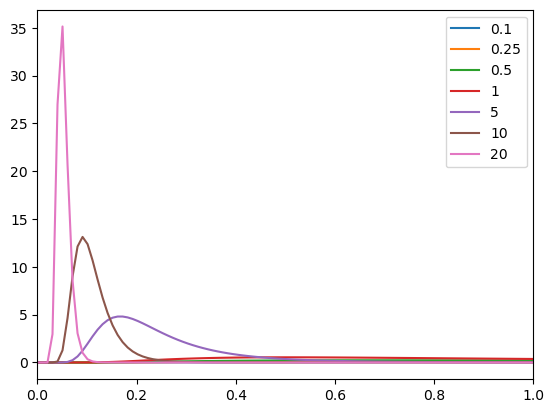

In [6]:
plt.figure()
xs = np.linspace(0,1,100)
for sc in [0.1,0.25,0.5,1,5,10,20]:
    plt.plot(xs,st.invgamma(sc).pdf(xs),label=str(sc))
plt.legend()
plt.xlim(0,1)
plt.show()

In [7]:
test_rng = np.random.default_rng(42)

In [8]:
test_prior = GalacticBinaryPrior(test_rng)

In [9]:
pop_theta = {'m_mu':np.array([0.6]),'m_sigma':np.array([0.15]),
             # 'd_mu':np.array([30]),'d_sigma':np.array([10]),
             'd_gamma_a':np.array([4]),'d_gamma_b':np.array([4]),
             'a_alpha':np.array([1/2])}
test_prior.condition(pop_theta)

In [10]:
samps = test_prior.sample_conditional(int(1e7))

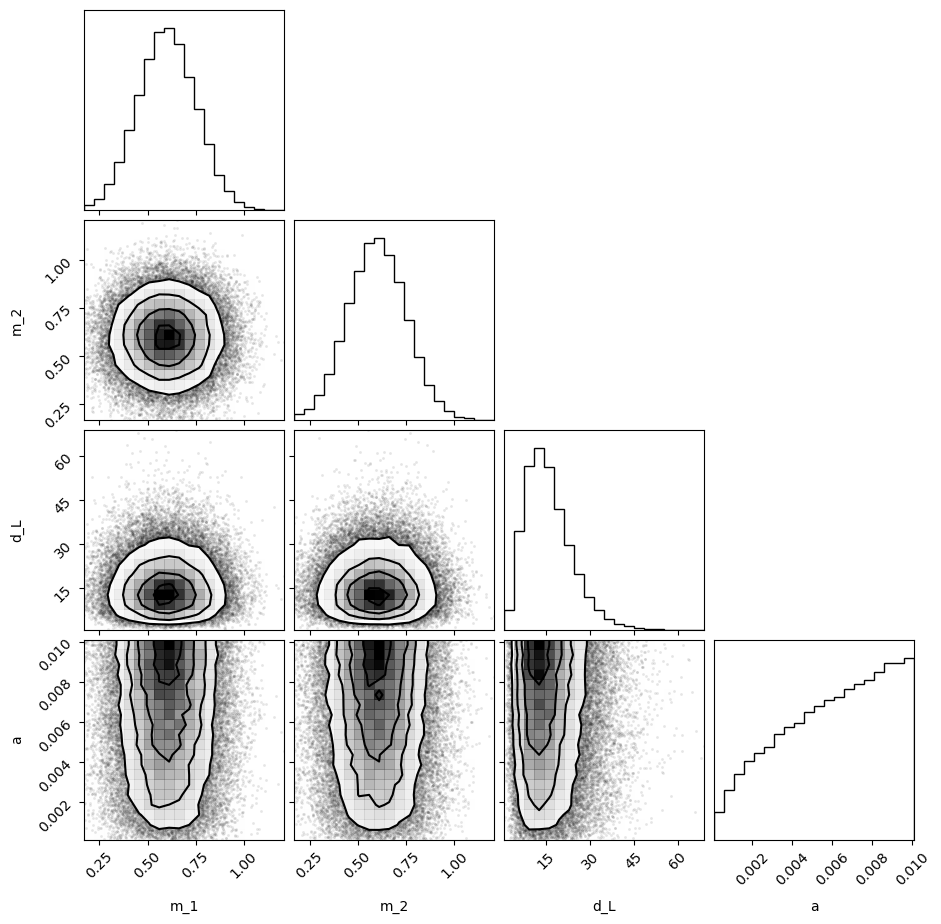

In [11]:
plt.close()
fig = corner(samps[:,::200].T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [12]:
def get_mc(m_1,m_2):
    return (m_1*m_2)**(3/5) / (m_1+m_2)**(1/5)
def get_amp_freq(theta):
    m_1 = theta[0]*(1*u.Msun).to(u.kg).value ## to kg
    m_2 = theta[1]*(1*u.Msun).to(u.kg).value ## to kg
    d_L = theta[2]*(1*u.kpc).to(u.m).value ## to m
    a = theta[3]*(1*u.AU).to(u.m).value ## to m
    G = 6.6743e-11 ## m^3 kg^-1 s^-2
    c = 2.99792458e8 ## m/s
    amp = (8/np.sqrt(5)) * (G**2/c**4) * (m_1*m_2)/(d_L*a)
    fgw = 1/np.pi * np.sqrt(G*(m_1+m_2)/a**3)
    return amp, fgw

In [13]:
amps, fgws = get_amp_freq(samps)

In [14]:
arr = np.array([np.log10(fgws),np.log10(amps)])

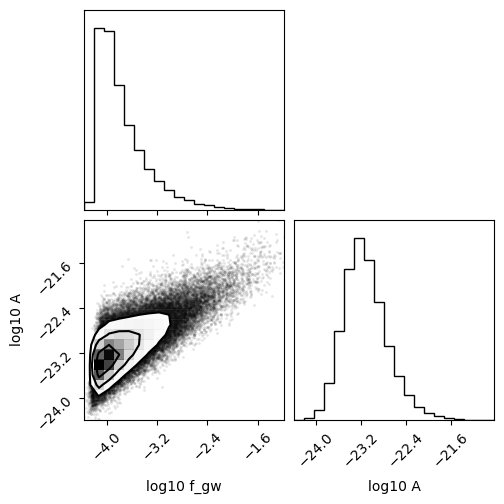

In [15]:
plt.close()
fig = corner(arr[:,::100].T,labels=['log10 f_gw','log10 A'])
plt.show()

In [16]:
np.max(amps)

4.188160604344195e-20

In [17]:
## simple hist to see spectra approx
bin_width = 1e-5
dur_eff = 1/bin_width
bins = np.arange(1e-4,1e-1,bin_width)

approx_PSD = dur_eff * amps**2

## bin
PSD_binned, edges = np.histogram(fgws,bins=bins,weights=approx_PSD)

In [18]:
lisa_rx = lw.psd.approximate_response_function((bins[1:]-bin_width/2)*u.Hz,fstar=19.09*u.mHz).value

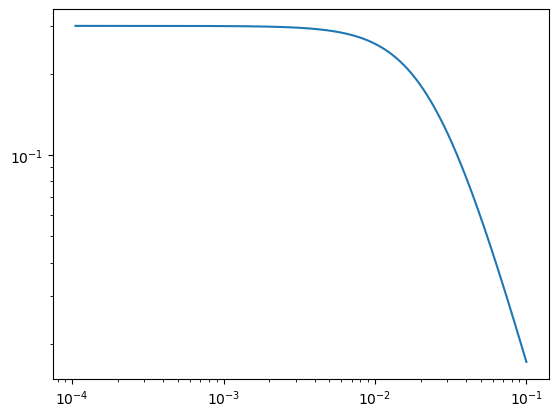

In [19]:
plt.figure()
plt.loglog(bins[1:]-bin_width/2,lisa_rx)

In [20]:
## rapid sorting
## from foreground.py
def rebin_calc_Nij(A, noisePSD, lowamp_PSD, wts, duration, duration_eff):
    '''
    Make the per-frequency SNR vector (dim 1xN_dwd)
    
    Arguments
    ------------
    A (float array)      : Sorted (ascending) DWD amplitudes
    noisePSD (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
    wts (float or array) : weights from fiducial population (1 for now)
    '''
#     np.sqrt(dur_noise*np.array(df['amplitude'])[current_unres_idx]**2 / (4*current_latf))
#     return np.sqrt(0.5*duration*A**2/((noisePSD + 0.5 * duration_eff * (np.cumsum(wts*A**2) - wts*A**2) )))
    return np.sqrt(duration*A**2/((noisePSD + lowamp_PSD + duration_eff * (np.cumsum(wts*A**2) - wts*A**2) )))
#     return A / (noisePSD + np.cumsum(wts*A))
def rebin_sort_threshold(binaries,fs_full,fs_noise,noisePSD,duration,LISA_rx,wts=1,snr_thresh=7,compute_fac=0.1):
    '''
    Function to bin by frequency, then for the vector of binaries in each frequency bin, sort them by amplitude.
    
    Arguments
    -----------
    binaries (dataframe) : df with binary info. Will rephrase arguments in terms of the specific needed components later.
    fs_full (float array) : data frequencies
    noisePSD  (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
    LISA_rx (float or array) : Approximate LISA response function evaluated at fs_full
    wts (float or array) : weights from fiducial population (1 for now)
    snr_thresh (float)    : the SNR threshold to condition resolved vs. unresolved on
    quantile (float : Percent (from bottom) of sources in a given bin to assume are unresolved. Must be 0 < q < 1.
    
    Returns
    -----------
    foreground_amp (array) : Stochastic foreground from unresolved sources, evaluated at fs_full.
    N_res (int)            : Number of resolved DWDs
    res_idx (array)        : Indices of the binaries dataframe for resolved DWDs.
    unres_idx (array)      : Indices of the binaries dataframe for unresolved DWDs.
    '''
    # dwd_fs = np.array(binaries['fs'])
    # dwd_amps = np.array(binaries['hs'])

    dwd_fs = binaries[0,:]
    dwd_amps = binaries[1,:]
    
    dwd_idx = np.arange(len(dwd_amps))
    ## constrain to frequencies where we have a noise curve
    if fs_noise[0] == 0:
        fs_noise = fs_noise[1:]
        noisePSD = noisePSD[1:]
    noise_f_mask = (fs_full>=fs_noise.min()) & (fs_full<=fs_noise.max())
    fs_full = fs_full[noise_f_mask]
    ## find which noise frequency corresponds to each frequency bin
#     noise_f_idx = np.digitize(fs_full,fs_noise-(fs_noise[1]-fs_noise[0])/2)
    
    ## bin the binaries by frequency
    ## first, find which frequency bin each binary is in
    delf = fs_full[1] - fs_full[0]
    f_idx = np.digitize(dwd_fs,fs_full+0.5*delf)
    duration_eff = 1/delf ## effective duration for new frequency resolution
    
    
    ## now created a ragged list of arrays of varying sizes, corresponding to N_dwd(f_i)
    ## each entry is an array containing the indices of the DWDs in that bin, sorted by ascending amplitude*
    ##     * under the current assumption of uniform responses, this is equivalent to sorting by the naive SNR
    ##       (!! -- we will need to refine this in future)
    fbin_res_list = []
    foreground_amp = np.zeros(len(fs_full))
    iter_range = len(fs_full)
    for i in tqdm(range(iter_range)):
        fbin_mask_i = np.array(f_idx == i)
        fbin_amps_i = dwd_amps[fbin_mask_i]*np.sqrt(LISA_rx[i]) ## sqrt because we square the amplitudes to get Sgw
        fbin_sort_i = np.argsort(fbin_amps_i)
        re_sort_i = np.argsort(fbin_sort_i) ## this will allow us to later return to the original order
        sorted_fbin_amps_i = fbin_amps_i[fbin_sort_i]
        if len(sorted_fbin_amps_i) != 0:
            hightail_filt = sorted_fbin_amps_i > sorted_fbin_amps_i[int((1-compute_fac)*len(sorted_fbin_amps_i))]
            # print(np.sum(hightail_filt)/len(sorted_fbin_amps_i))
            hightail_idx = np.where(hightail_filt)
            lowamp_idx = np.where(np.invert(hightail_filt))
            # bin_amps_i[fbin_sort_i] > np.quantile(fbin_amps_i[fbin_sort_i],0.9)
            lowamp_PSD = duration_eff*np.sum(wts*sorted_fbin_amps_i[np.invert(hightail_filt)]**2)
            # print(lowamp_PSD,noisePSD[i])
            
            high_tail = sorted_fbin_amps_i[hightail_filt]
            
            fbin_Nij = rebin_calc_Nij(high_tail,noisePSD[i],lowamp_PSD,wts,duration,duration_eff)
            # if fbin_Nij.size > 0:
                # print(np.max(fbin_Nij))
            res_mask_i = np.zeros(len(sorted_fbin_amps_i),dtype='bool')
            res_mask_i[hightail_idx] = fbin_Nij>=snr_thresh
            # print(np.sum(res_mask_i))
            res_mask_i_resort = res_mask_i[re_sort_i]
            fbin_res_list.append(dwd_idx[fbin_mask_i][res_mask_i_resort])
            
            foreground_amp[i] = np.sum(fbin_amps_i[np.invert(res_mask_i_resort)]**2)
        else:
            foreground_amp[i] = 0

    ##unpack the binned list
    res_idx = np.array([],dtype=int)
    for i, arr in enumerate(fbin_res_list):
        res_idx = np.append(res_idx,arr)
    N_res = len(res_idx)
    unres_idx = np.isin(dwd_idx,res_idx,invert=True)
    
    return foreground_amp, fs_full, N_res, res_idx, unres_idx


def rebin_sort_threshold_noprog(binaries,fs_full,fs_noise,noisePSD,duration,LISA_rx,wts=1,snr_thresh=7,compute_fac=0.1):
    '''
    Function to bin by frequency, then for the vector of binaries in each frequency bin, sort them by amplitude.
    
    Arguments
    -----------
    binaries (dataframe) : df with binary info. Will rephrase arguments in terms of the specific needed components later.
    fs_full (float array) : data frequencies
    noisePSD  (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
    LISA_rx (float or array) : Approximate LISA response function evaluated at fs_full
    wts (float or array) : weights from fiducial population (1 for now)
    snr_thresh (float)    : the SNR threshold to condition resolved vs. unresolved on
    quantile (float : Percent (from bottom) of sources in a given bin to assume are unresolved. Must be 0 < q < 1.
    
    Returns
    -----------
    foreground_amp (array) : Stochastic foreground from unresolved sources, evaluated at fs_full.
    N_res (int)            : Number of resolved DWDs
    res_idx (array)        : Indices of the binaries dataframe for resolved DWDs.
    unres_idx (array)      : Indices of the binaries dataframe for unresolved DWDs.
    '''
    # dwd_fs = np.array(binaries['fs'])
    # dwd_amps = np.array(binaries['hs'])

    dwd_fs = binaries[0,:]
    dwd_amps = binaries[1,:]
    
    dwd_idx = np.arange(len(dwd_amps))
    ## constrain to frequencies where we have a noise curve
    if fs_noise[0] == 0:
        fs_noise = fs_noise[1:]
        noisePSD = noisePSD[1:]
    noise_f_mask = (fs_full>=fs_noise.min()) & (fs_full<=fs_noise.max())
    fs_full = fs_full[noise_f_mask]
    ## find which noise frequency corresponds to each frequency bin
#     noise_f_idx = np.digitize(fs_full,fs_noise-(fs_noise[1]-fs_noise[0])/2)
    
    ## bin the binaries by frequency
    ## first, find which frequency bin each binary is in
    delf = fs_full[1] - fs_full[0]
    f_idx = np.digitize(dwd_fs,fs_full+0.5*delf)
    duration_eff = 1/delf ## effective duration for new frequency resolution
    
    
    ## now created a ragged list of arrays of varying sizes, corresponding to N_dwd(f_i)
    ## each entry is an array containing the indices of the DWDs in that bin, sorted by ascending amplitude*
    ##     * under the current assumption of uniform responses, this is equivalent to sorting by the naive SNR
    ##       (!! -- we will need to refine this in future)
    fbin_res_list = []
    foreground_amp = np.zeros(len(fs_full))
    iter_range = len(fs_full)
    for i in range(iter_range):
        fbin_mask_i = np.array(f_idx == i)
        fbin_amps_i = dwd_amps[fbin_mask_i]*np.sqrt(LISA_rx[i]) ## sqrt because we square the amplitudes to get Sgw
        fbin_sort_i = np.argsort(fbin_amps_i)
        re_sort_i = np.argsort(fbin_sort_i) ## this will allow us to later return to the original order
        sorted_fbin_amps_i = fbin_amps_i[fbin_sort_i]
        if len(sorted_fbin_amps_i) != 0:
            hightail_filt = sorted_fbin_amps_i > sorted_fbin_amps_i[int((1-compute_frac)*len(sorted_fbin_amps_i))]
            # print(np.sum(hightail_filt)/len(sorted_fbin_amps_i))
            hightail_idx = np.where(hightail_filt)
            lowamp_idx = np.where(np.invert(hightail_filt))
            # bin_amps_i[fbin_sort_i] > np.quantile(fbin_amps_i[fbin_sort_i],0.9)
            lowamp_PSD = duration_eff*np.sum(wts*sorted_fbin_amps_i[np.invert(hightail_filt)]**2)
            # print(lowamp_PSD,noisePSD[i])
            
            high_tail = sorted_fbin_amps_i[hightail_filt]
            
            fbin_Nij = rebin_calc_Nij(high_tail,noisePSD[i],lowamp_PSD,wts,duration,duration_eff)
            # if fbin_Nij.size > 0:
                # print(np.max(fbin_Nij))
            res_mask_i = np.zeros(len(sorted_fbin_amps_i),dtype='bool')
            res_mask_i[hightail_idx] = fbin_Nij>=snr_thresh
            # print(np.sum(res_mask_i))
            res_mask_i_resort = res_mask_i[re_sort_i]
            fbin_res_list.append(dwd_idx[fbin_mask_i][res_mask_i_resort])
            
            foreground_amp[i] = np.sum(fbin_amps_i[np.invert(res_mask_i_resort)]**2)
        else:
            foreground_amp[i] = 0

    ##unpack the binned list
    res_idx = np.array([],dtype=int)
    for i, arr in enumerate(fbin_res_list):
        res_idx = np.append(res_idx,arr)
    N_res = len(res_idx)
    unres_idx = np.isin(dwd_idx,res_idx,invert=True)
    
    return foreground_amp, fs_full, N_res, res_idx, unres_idx


In [21]:
## pre-filter to low frequencies
binaries = 10**(arr)
lowf_filt = (binaries[0] <= 1e-2)#*(binaries[0] >= 8e-4)
binaries = binaries[:,lowf_filt]
lowf_bins = bins[bins <= 1e-2]

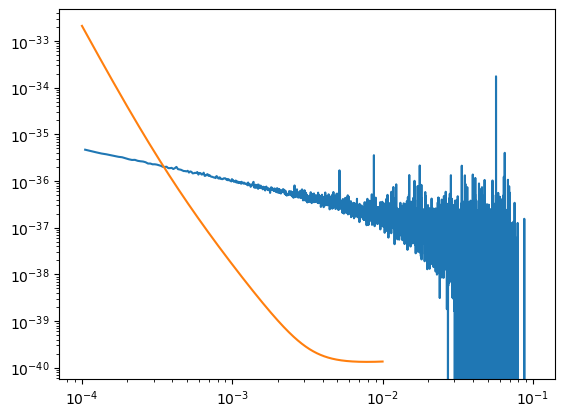

In [22]:
plt.figure()
plt.loglog(bins[1:]-bin_width/2,PSD_binned)
plt.loglog(lowf_bins,lw.psd.lisa_psd(lowf_bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
# plt.xlim(1e-4,1e-3)
plt.show()

In [23]:
## test sort
# fbins_rebin_fl = np.arange(1e-4,1e-1,bin_width)
fg_sort, fs_sort, N_res, res_idx, unres_idx = rebin_sort_threshold(binaries,
                                                                 lowf_bins,
                                                                 lowf_bins,
                                                                 lw.psd.lisa_psd(lowf_bins*u.Hz,
                                                                                 t_obs=4*u.yr,
                                                                                 confusion_noise=None).value,
                                                                 (4*u.yr).to(u.s).value,
                                                                 lw.psd.approximate_response_function(bins*u.Hz,
                                                                                                      19.09*u.mHz).value,
                                                                 wts=1,snr_thresh=7)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 991/991 [00:08<00:00, 119.48it/s]


In [24]:
len(res_idx)

4395

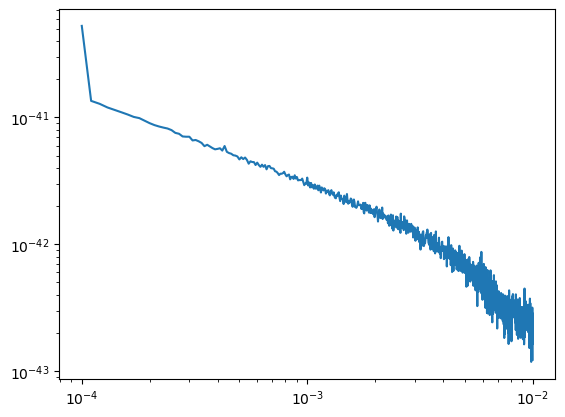

In [25]:
plt.figure()
plt.loglog(fs_sort,fg_sort)


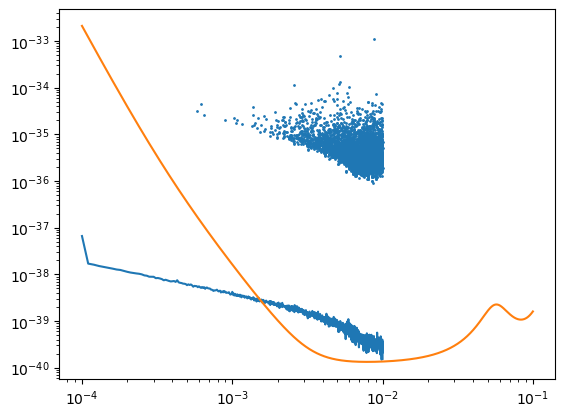

In [26]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(lowf_bins,((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort)
plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
                                   *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.show()

In [27]:
## test sort
# fbins_rebin_fl = np.arange(1e-4,1e-1,bin_width)
fg_sort, fs_sort, N_res, res_idx, unres_idx = rebin_sort_threshold(binaries,
                                                                 lowf_bins,
                                                                 lowf_bins,
                                                                 lw.psd.lisa_psd(lowf_bins*u.Hz,
                                                                                 t_obs=4*u.yr,
                                                                                 confusion_noise=None).value,
                                                                 (4*u.yr).to(u.s).value,
                                                                 lw.psd.approximate_response_function(bins*u.Hz,
                                                                                                      19.09*u.mHz).value,
                                                                 wts=1,snr_thresh=7,
                                                                  compute_fac=0.3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 991/991 [00:08<00:00, 114.76it/s]


In [28]:
len(res_idx)

7791

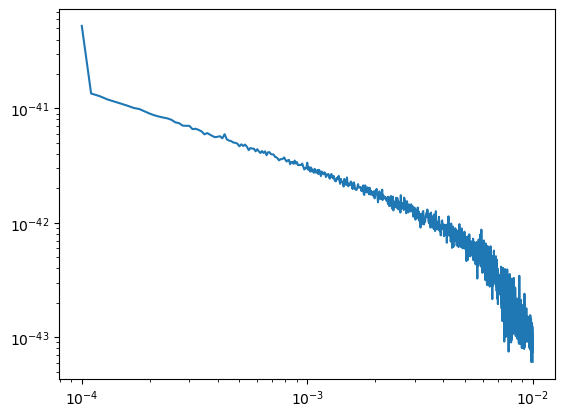

In [29]:
plt.figure()
plt.loglog(fs_sort,fg_sort)


Noting from the below that we need to solve the uniqueness problem!! It becomes relevant as you start to see source discreteness.

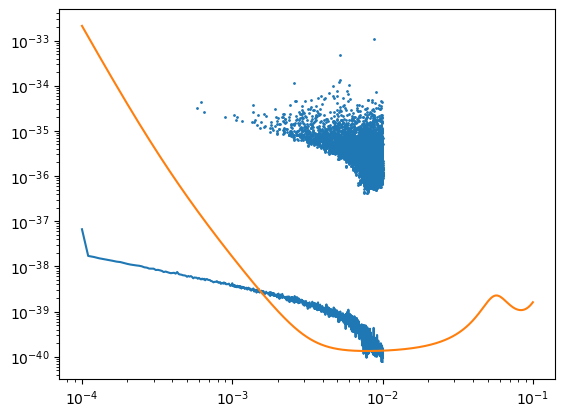

In [30]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(lowf_bins,((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort)
plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
                                   *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.show()

But for now, let's just keep to the "easy" bit.

In [31]:
## pre-filter to low frequencies
binaries = 10**(arr)
lowf_filt = (binaries[0] <= 6e-3)*(binaries[0] >= 1e-4)
binaries = binaries[:,lowf_filt]
lowf_bins = bins[(bins <= 5e-3)]

In [32]:
## test sort
# fbins_rebin_fl = np.arange(1e-4,1e-1,bin_width)
fg_sort, fs_sort, N_res, res_idx, unres_idx = rebin_sort_threshold(binaries,
                                                                 lowf_bins,
                                                                 lowf_bins,
                                                                 lw.psd.lisa_psd(lowf_bins*u.Hz,
                                                                                 t_obs=4*u.yr,
                                                                                 confusion_noise=None).value,
                                                                 (4*u.yr).to(u.s).value,
                                                                 lw.psd.approximate_response_function(bins*u.Hz,
                                                                                                      19.09*u.mHz).value,
                                                                 wts=1,snr_thresh=7,
                                                                  compute_fac=0.3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491/491 [00:03<00:00, 149.55it/s]


In [33]:
len(res_idx)

733

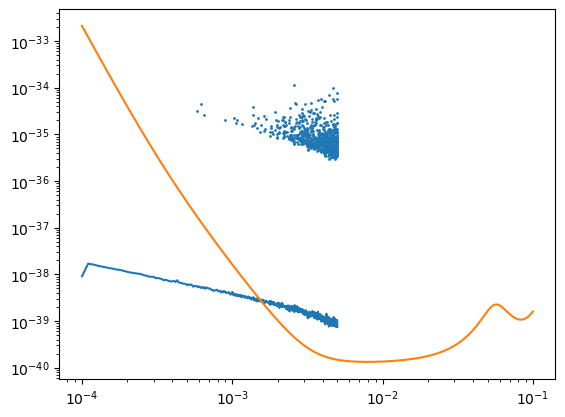

In [34]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(lowf_bins,((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort)
plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
                                   *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.show()

Okay, this is good enough for jazz for the toy model. Next up: 

- Simulate analytic, known likelihoods for each of the resolved binaries
- Simulate power law uncertainty on the foreground spectrum
- Fix $N_{\rm res}(f)$ as an observable
- Build direct implementation of the hierarchical model
- Ensure that any samples at higher-frequencies return the prior probability

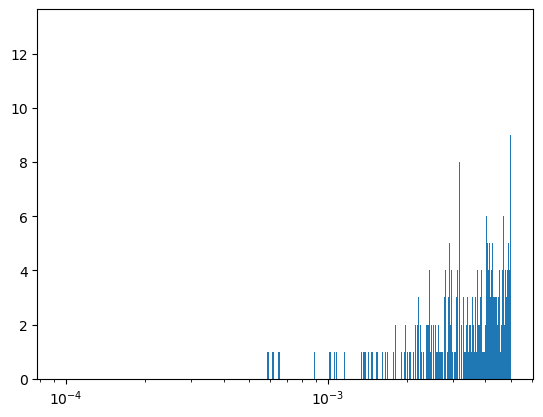

In [35]:
plt.figure()
bin_width = lowf_bins[1] - lowf_bins[0]
N_res_i, _, _ = plt.hist(binaries[0][res_idx],bins=np.append(lowf_bins - bin_width/2, lowf_bins[-1]+bin_width/2))
plt.xscale('log')
plt.show()

In [36]:
N_res_i.shape, lowf_bins.shape, fg_sort.shape

((491,), (491,), (491,))

In [37]:
res_idx.shape

(733,)

Now let's make some simulated likelihoods for the resolved binaries and unresolved spectrum, to abstract away the realities of the Global Fit.

For resolved GBs, Gaussian on $A$ and $f$, with more uncertainty on $A$. Bonus: make lower-frequency sources have more uncertainty.

For the foreground, take (Gaussian) uncertainty on a power law model amplitude (fixed slope of 2/3) and translate to $A_{FG}(f_i)$. Bonus: allow for scatter in each bin to enable inference of $N_{{\rm unres},i}$.

In [38]:
def vectorized_gaussian_logpdf(X, means, covariances):
    """
    Compute log N(x_i; mu_i, sigma_i) for each x_i, mu_i, sigma_i.
    From Daniel W. on StackOverflow (https://stackoverflow.com/questions/48686934/numpy-vectorization-of-multivariate-normal)
    Args:
        X : shape (n, d)
            Data points
        means : shape (n, d)
            Mean vectors
        covariances : shape (n, d)
            Diagonal covariance matrices
    Returns:
        logpdfs : shape (n,)
            Log probabilities
    """
    _, d = X.shape
    constant = d * np.log(2 * np.pi)
    log_determinants = np.log(np.prod(covariances, axis=1))
    deviations = X - means
    inverses = 1 / covariances
    return -0.5 * (constant + log_determinants + np.sum(deviations * inverses * deviations, axis=1))

In [39]:
## make some basic faux likelihoods for the GBs
class Likelihood():
    '''
    Base class for the analytic likelihood methods.
    '''

    def const_covar_gaussian_logpdf(self, theta, mu_vec, cov):
        """
        Compute log N(x_i; mu_i, sigma_i) for each x_i, mu_i, sigma_i.
        From Daniel W. on StackOverflow (https://stackoverflow.com/questions/48686934/numpy-vectorization-of-multivariate-normal)
        Args:
            X : shape (n, d)
                Data points
            means : shape (n, d)
                Mean vectors
            covariances : shape (n, d)
                Diagonal covariance matrices
        Returns:
            logpdfs : shape (n,)
                Log probabilities
        """
        _, d = theta.shape
        constant = d * np.log(2 * np.pi)
        log_determinants = np.log(np.prod(np.diag(cov)))
        deviations = theta - mu_vec
        inverses = 1/np.diag(cov)
        return -0.5 * (constant + log_determinants + np.sum(deviations * inverses * deviations, axis=1))

    def array_gaussian_logpdf(self, theta_vec, mu_vec, sigma):
        """
        Compute log N(x_i; mu_i, sigma_i) for each x_i, mu_i, sigma_i.
        From Daniel W. on StackOverflow (https://stackoverflow.com/questions/48686934/numpy-vectorization-of-multivariate-normal)
        Args:
            X : shape (n, d)
                Data points
            means : shape (n, d)
                Mean vectors
            covariances : shape (n, d)
                Diagonal covariance matrices
        Returns:
            logpdfs : shape (n,)
                Log probabilities
        """
        # d = theta.shape
        # constant = np.log(2 * np.pi)

        return - np.sum((theta_vec - mu_vec)**2)/(2*sigma)


        
        # log_determinants = np.log(np.prod(np.diag(cov)))
        # deviations = theta - mu_vec
        # inverses = 1/np.diag(cov)
        # return -0.5 * (constant + log_determinants + np.sum(deviations * inverses * deviations, axis=1))
    
    def vectorized_gaussian_logpdf(self, theta, mu_vec, cov_vec):
        """
        Compute log N(x_i; mu_i, sigma_i) for each x_i, mu_i, sigma_i.
        From Daniel W. on StackOverflow (https://stackoverflow.com/questions/48686934/numpy-vectorization-of-multivariate-normal)
        Args:
            X : shape (n, d)
                Data points
            means : shape (n, d)
                Mean vectors
            covariances : shape (n, d)
                Diagonal covariance matrices
        Returns:
            logpdfs : shape (n,)
                Log probabilities
        """
        _, d = theta.shape
        constant = d * np.log(2 * np.pi)
        log_determinants = np.log(np.prod(cov_vec, axis=1))
        deviations = theta - mu_vec
        inverses = 1 / cov_vec
        return -0.5 * (constant + log_determinants + np.sum(deviations * inverses * deviations, axis=1))

class GB_Likelihood(Likelihood):
    '''
    GB analytic likelihood class
    '''

    def __init__(self,theta_true,cov,sigma_of_f=False):
        '''
        theta_true are the true simulated parameter values, of shape N_res x N_theta
        sigma is the N_theta x N_theta (N_theta x N_theta x N_f) or covariance matrix
        sigma_of_f (bool) : Whether the provided covariance is a function of frequency
        '''
        
        if not sigma_of_f:
            ## calculate the observed means with scatter from true vals
            self.mu_vec = np.array([st.multivariate_normal.rvs(mean=theta_true[ii,:],
                                                               cov=cov,size=1) for ii in range(theta_true.shape[0])])
            self.cov = cov
            self.ln_prob = self.ln_prob_const_sigma
        else:
            self.mu_vec = st.multivariate_normal.rvs(mean=theta_true,cov=cov,size=1)
            self.cov_vec = cov
            self.ln_prob = self.ln_prob_sigma_of_f
            raise(NotImplementedError)
    
    # def ln_prob(self,theta):
    #     return -0.5*(theta - self.mu_vec).T @ np.inv(self.cov) @ (theta - self.mu_vec)
    def ln_prob_const_sigma(self,theta):
        return self.const_covar_gaussian_logpdf(theta,self.mu_vec,self.cov)
    def ln_prob_sigma_of_f(self,theta):
        return self.vectorized_gaussian_logpdf(theta,self.mu_vec,self.cov_vec)

class Nres_Likelihood(Likelihood):
    '''
    N_res Poisson likelihood
    '''

    def __init__(self,N_res_obs):
        '''
        N_res_obs (Number of resolved binaries)
        '''

        self.N_res_obs = N_res_obs
        self.base_dist = st.poisson(self.N_res_obs)
        self.ln_prob = self.ln_conditional_Poisson

    # def ln_conditional_Poisson(self,N_res_theta):

    #     return -self.N_res_obs + N_res_theta*np.log(N_res_obs) - np.log(factorial(N_res_theta))

    ## okay for now, just use the scipy stats one and take the log
    def ln_conditional_Poisson(self,N_res_theta):
        return np.log(self.base_dist.pmf(N_res_theta))

class FG_Likelihood(Likelihood):
    '''
    Foreground analytic likelihood class
    '''

    def __init__(self,spec_data,cov,sigma_of_f=False):
        '''
        spec_data (foreground PSD)
        cov (!! needs to be diagonal and in units of log amplitude)
        '''
        
        if not sigma_of_f:
            ## calculate the observed means with scatter from true vals
            self.mu_vec = spec_data, #st.multivariate_normal.rvs(mean=spec_data,
                                    # cov=cov,size=1)
            self.cov = cov
            self.ln_prob = self.ln_prob_const_sigma
        else:
            self.mu_vec = theta_true ## st.multivariate_normal.rvs(mean=theta_true,cov=cov,size=1)
            self.cov_vec = cov
            self.ln_prob = self.ln_prob_sigma_of_f
            raise(NotImplementedError)
    
    # def ln_prob(self,theta):
    #     return -0.5*(theta - self.mu_vec).T @ np.inv(self.cov) @ (theta - self.mu_vec)
    def ln_prob_const_sigma(self,theta_spec):
        return self.array_gaussian_logpdf(np.log10(theta_spec),np.log10(self.mu_vec),self.cov)
    def ln_prob_sigma_of_f(self,theta_spec):
        return self.vectorized_gaussian_logpdf(theta_spec,self.mu_vec,self.cov_vec)

In [40]:
res_phenom_thetas = binaries[:,res_idx]

In [41]:
res_phenom_thetas.shape

(2, 733)

In [42]:
log_res_phenom_thetas = np.log10(res_phenom_thetas)

In [43]:
log_res_phenom_thetas

array([[ -3.23190288,  -3.2104149 ,  -3.18764022, ...,  -2.30065996,
         -2.30107413,  -2.3012903 ],
       [-21.04026568, -20.96672135, -21.08147323, ..., -21.34727148,
        -21.39076874, -21.45448109]])

In [44]:
np.identity(2)

array([[1., 0.],
       [0., 1.]])

In [45]:
# st.multivariate_normal.rvs(mean=np.ones((2,10)),cov=np.identity(2))

In [46]:
np.abs(1 - 10**0.000001) / 1e-3

0.002302587744029694

In [47]:
## [delta logf 0]
## [0 delta logA]
test_sigma = np.array([[1e-6,0],[0,0.001]])
test_gbl = GB_Likelihood(log_res_phenom_thetas.T,cov=test_sigma)

In [48]:
test_gbl.mu_vec.shape

(733, 2)

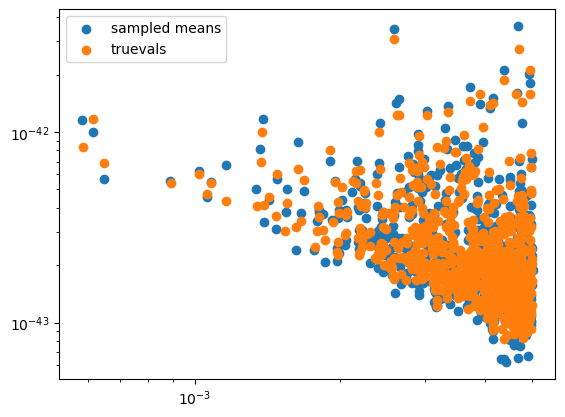

In [49]:
plt.scatter(10**test_gbl.mu_vec[:,0],10**(2*test_gbl.mu_vec[:,1]),label='sampled means')
plt.scatter(res_phenom_thetas[0,:],res_phenom_thetas[1,:]**2,label='truevals')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [130]:
np.atleast_1d(1)

array([1])

In [50]:
log_res_phenom_thetas[:,0]

array([ -3.23190288, -21.04026568])

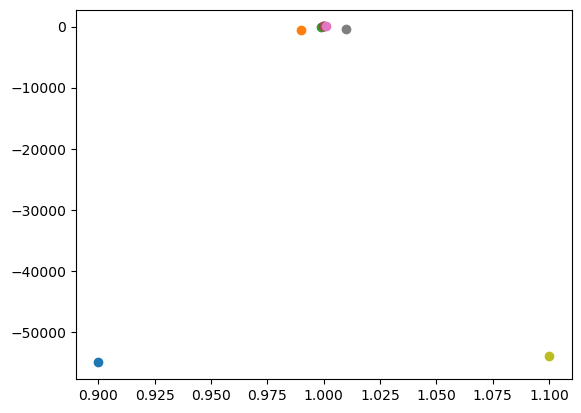

In [51]:
plt.figure()
deltas = np.array([0.9,0.99,0.999,0.9999,1,1.0001,1.001,1.01,1.1])
for i in range(len(deltas)):
    plt.scatter(deltas[i],test_gbl.ln_prob(log_res_phenom_thetas.T*deltas[i])[0])
plt.show()

Okay great, that looks vaguely Gaussian. Now we build the numpyro engine.

For each frequency bin, this needs to (eventually):

- draw $\Lambda=\{ N_{\rm tot}, \mu_m, \sigma_m, \alpha_f. d_a, d_b \}$
- Calculate $\lambda_{f_i}(N_{\rm tot},\alpha_f)$, the Poisson rate of GBs (resolved and unresolved) in freqency bin $i$
- draw $N(f_i)$
- in each bin $f_i$, draw $N(f_i)$ binaries with $\vec\theta_{ij} = \{m_1, m_2, d_L\}$

Initial simplification: assume $N_{\rm tot}$ and $\alpha_f=2/3$ are known

In [140]:
class PopulationHyperPrior():
    '''
    Class for the actual hyperparameters.
    '''

    def __init__(self,hyperprior_dict=None):

        '''.
        For now, set defaults but we can adjust later.
        '''

        if hyperprior_dict is None:

            hyperprior_dict = {'m_mu':st.norm(loc=0.6,scale=0.05),
                               'm_sigma':st.invgamma(5),
                               'd_gamma_a':st.uniform(loc=1,scale=9), ## these are pretty arbitrary
                               'd_gamma_b':st.uniform(loc=1,scale=9), ## these are pretty arbitrary
                               'a_alpha':st.uniform(0.25,1.0)
                              }
        self.hyperprior_dict = hyperprior_dict
        return

    def sample(self,N=1):
        return {key:self.hyperprior_dict[key].rvs(size=N) for key in self.hyperprior_dict.keys()}

class PopModel():
    '''
    Class to house the overall population model.
    '''

    def __init__(self,Ntot,rng,fbins='default',Tobs=4*u.yr,Nsamp=1):
        
        self.hyperprior = PopulationHyperPrior()
        self.hpar_names = [key for key in self.hyperprior.hyperprior_dict.keys()]
        
        self.gbprior = GalacticBinaryPrior(rng)

        self.N = int(Ntot)

        if type(fbins) is str and fbins == 'default':
            self.bin_width = 1e-5
            dur_eff = 1/bin_width
            self.fbins = np.arange(1e-4,5e-3,bin_width)
        else:
            self.fbins = fbins
            self.bin_width = self.fbins[1] - self.fbins[0]

        self.Tobs = Tobs.to(u.s).value

        self.approx_lisa_psd = lw.psd.lisa_psd(self.fbins*u.Hz,t_obs=self.Tobs*u.s,confusion_noise=None).value

        self.approx_lisa_rx = lw.psd.approximate_response_function(self.fbins*u.Hz,19.09*u.mHz).value

        self.Nsamp = Nsamp

        
        return

    def construct_likelihood(self,data):
        '''
        Wrapper to build all the likelihoods
        '''

        fg_data = data['fg']
        fg_sigma =data['fg_sigma']
        N_res_data = data['Nres']

        self.construct_fg_likelihood(fg_data,fg_sigma)
        self.construct_Nres_likelihood(N_res_data)

        return
    
    def construct_fg_likelihood(self,fg_data,fg_sigma):
        '''
        Method to attach the foreground likelihood to the PopModel,
        '''

        self.fg_like = FG_Likelihood(fg_data,fg_sigma)
        self.fg_ln_prob = self.fg_like.ln_prob

        return

    def construct_Nres_likelihood(self,N_res_obs):
        '''
        Method to attach the Poisson likelihood for the number of resolved binaries to the PopModel
        '''
        self.Nres_like = Nres_Likelihood(N_res_obs)
        self.N_res_ln_prob = self.Nres_like.ln_prob

        return
        
        
            
    @staticmethod
    def rebin_calc_Nij(A, noisePSD, lowamp_PSD, wts, duration, duration_eff):
        '''
        Make the per-frequency SNR vector (dim 1xN_dwd)
        
        Arguments
        ------------
        A (float array)      : Sorted (ascending) DWD amplitudes
        noisePSD (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
        lowamp_PSD (float)   : Level of the low-amplitude contribution to the foreground PSD in the relevant frequency bin
        wts (float or array) : weights from fiducial population (1 for now)
        duration (float)     : duration in seconds of the observing run. Assume 4 years in general.
        duration_eff (float) : Effective duration in seconds given the frequency binning, i.e. 1/f_bin_width
        '''
        return np.sqrt(duration*A**2/((noisePSD + lowamp_PSD + duration_eff * (np.cumsum(wts*A**2) - wts*A**2) )))

    @staticmethod
    def rebin_sort_threshold(binaries,fs,noisePSD,duration,LISA_rx,wts=1,snr_thresh=7,compute_frac=0.1):
        '''
        Function to bin by frequency, then for the vector of binaries in each frequency bin, sort them by amplitude.
        
        Arguments
        -----------
        binaries (dataframe) : df with binary info. Will rephrase arguments in terms of the specific needed components later.
        fs (float array) : data frequencies
        noisePSD  (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
        LISA_rx (float or array) : Approximate LISA response function evaluated at fs_full
        wts (float or array) : weights from fiducial population (1 for now)
        snr_thresh (float)    : the SNR threshold to condition resolved vs. unresolved on
        quantile (float : Percent (from bottom) of sources in a given bin to assume are unresolved. Must be 0 < q < 1.
        
        Returns
        -----------
        foreground_amp (array) : Stochastic foreground from unresolved sources, evaluated at fs_full.
        N_res (int)            : Number of resolved DWDs
        res_idx (array)        : Indices of the binaries dataframe for resolved DWDs.
        unres_idx (array)      : Indices of the binaries dataframe for unresolved DWDs.
        '''
        # dwd_fs = np.array(binaries['fs'])
        # dwd_amps = np.array(binaries['hs'])
    
        dwd_fs = binaries[0,:]
        dwd_amps = binaries[1,:]
        
        dwd_idx = np.arange(len(dwd_amps))
        ## constrain to frequencies where we have a noise curve
        fs_noise = fs ## lazy
        fs_full = fs ## lazy
        if fs_noise[0] == 0:
            fs_noise = fs_noise[1:]
            noisePSD = noisePSD[1:]
        noise_f_mask = (fs_full>=fs_noise.min()) & (fs_full<=fs_noise.max())
        fs_full = fs_full[noise_f_mask]
        ## find which noise frequency corresponds to each frequency bin
    #     noise_f_idx = np.digitize(fs_full,fs_noise-(fs_noise[1]-fs_noise[0])/2)
        
        ## bin the binaries by frequency
        ## first, find which frequency bin each binary is in
        delf = fs_full[1] - fs_full[0]
        f_idx = np.digitize(dwd_fs,fs_full+0.5*delf)
        duration_eff = 1/delf ## effective duration for new frequency resolution
        
        
        ## now created a ragged list of arrays of varying sizes, corresponding to N_dwd(f_i)
        ## each entry is an array containing the indices of the DWDs in that bin, sorted by ascending amplitude*
        ##     * under the current assumption of uniform responses, this is equivalent to sorting by the naive SNR
        ##       (!! -- we will need to refine this in future)
        fbin_res_list = []
        foreground_amp = np.zeros(len(fs_full))
        iter_range = len(fs_full)
        for i in range(iter_range):
            fbin_mask_i = np.array(f_idx == i)
            fbin_amps_i = dwd_amps[fbin_mask_i]*np.sqrt(LISA_rx[i]) ## sqrt because we square the amplitudes to get Sgw
            fbin_sort_i = np.argsort(fbin_amps_i)
            re_sort_i = np.argsort(fbin_sort_i) ## this will allow us to later return to the original order
            sorted_fbin_amps_i = fbin_amps_i[fbin_sort_i]
            if len(sorted_fbin_amps_i) != 0:
                hightail_filt = sorted_fbin_amps_i > sorted_fbin_amps_i[int((1-compute_frac)*len(sorted_fbin_amps_i))]
                # print(np.sum(hightail_filt)/len(sorted_fbin_amps_i))
                hightail_idx = np.where(hightail_filt)
                lowamp_idx = np.where(np.invert(hightail_filt))
                # bin_amps_i[fbin_sort_i] > np.quantile(fbin_amps_i[fbin_sort_i],0.9)
                lowamp_PSD = duration_eff*np.sum(wts*sorted_fbin_amps_i[np.invert(hightail_filt)]**2)
                # print(lowamp_PSD,noisePSD[i])
                
                high_tail = sorted_fbin_amps_i[hightail_filt]
                
                fbin_Nij = rebin_calc_Nij(high_tail,noisePSD[i],lowamp_PSD,wts,duration,duration_eff)
                # if fbin_Nij.size > 0:
                    # print(np.max(fbin_Nij))
                res_mask_i = np.zeros(len(sorted_fbin_amps_i),dtype='bool')
                res_mask_i[hightail_idx] = fbin_Nij>=snr_thresh
                # print(np.sum(res_mask_i))
                res_mask_i_resort = res_mask_i[re_sort_i]
                fbin_res_list.append(dwd_idx[fbin_mask_i][res_mask_i_resort])
                
                foreground_amp[i] = np.sum(fbin_amps_i[np.invert(res_mask_i_resort)]**2)
            else:
                foreground_amp[i] = 0
    
        ##unpack the binned list
        res_idx = np.array([],dtype=int)
        for i, arr in enumerate(fbin_res_list):
            res_idx = np.append(res_idx,arr)
        N_res = len(res_idx)
        unres_idx = np.isin(dwd_idx,res_idx,invert=True)
        
        return foreground_amp, fs_full, N_res, res_idx, unres_idx

    
    def run_model(self,pop_theta=None):

        ## draw pop hyperparameters
        if pop_theta is None:
            pop_theta = self.hyperprior.sample(1)
        elif (type(pop_theta) is list) or (type(pop_theta) is np.ndarray):
            pop_theta = {key:np.atleast_1d(val) for key, val in zip(self.hpar_names,pop_theta)}
        ## condition the astro parameter distributions on the hyperprior draw
        self.gbprior.condition(pop_theta)

        ## draw a sample galaxy
        galaxy_draw = self.gbprior.sample_conditional(self.N)

        ## convert to phenomenological space
        amp_draws, fgw_draws = get_amp_freq(galaxy_draw)

        ## form array
        obs_draws = np.array([fgw_draws,amp_draws])
        
        ## sort into resolved and unresolved binaries
        fg_sort, fs_sort, N_res, res_idx, unres_idx = self.rebin_sort_threshold(obs_draws,
                                                                           self.fbins,
                                                                           self.approx_lisa_psd,
                                                                           self.Tobs,
                                                                           self.approx_lisa_rx,
                                                                           wts=1,
                                                                           snr_thresh=7,
                                                                           compute_frac=0.2)
        fg_psd = (self.Tobs / self.bin_width**(-1))*fg_sort

        ## lowest bin is not accurate, discard
        return self.fbins[1:], fg_psd[1:], N_res, res_idx

    def fg_N_ln_prob(self,pop_theta,return_spec=False):
        '''
        Function to get the model probability conditioned on only 
        the per-bin foreground amplitude and the total number of resolved binaries

        Eventually we can extend this to per-bin N_res
        '''
        # ## unpack data
        # N_res_obs = data['N_res']
        # fg_obs = data['fg']

        ## call the population model
        fbins, fg_psd, N_res, res_idx = self.run_model(pop_theta)

        ## call the fg likelihood
        ln_p_fg = self.fg_ln_prob(fg_psd)

        ln_p_Nres = self.N_res_ln_prob(N_res)

        if return_spec:
            return ln_p_fg + ln_p_Nres, [fbins[1:],fg_psd[1:],N_res]
        else:
            return ln_p_fg + ln_p_Nres

    def sample_likelihood(self,save_spec=False):

        new_chain = np.empty((len(self.hyperprior.hyperprior_dict)+1,self.Nsamp)) ## last column is for the likelihood
        if hasattr(self,'chain'):
            self.chain = np.append(self.chain,new_chain,axis=1)
        else:
            self.chain = new_chain

        specs = []
        Ns = []
        if save_spec:
            for ii in tqdm(range(self.Nsamp)):
                draw = self.hyperprior.sample(1)
                self.chain[:-1,ii] = np.array([draw[key] for key in draw.keys()]).flatten()
                self.chain[-1,ii], astro_result = self.fg_N_ln_prob(draw,return_spec=True)
                specs.append(astro_result[1])
                Ns.append(astro_result[2])
            return self.chain, astro_result[0], specs, Ns
        else:
            for ii in tqdm(range(self.Nsamp)):
                draw = self.hyperprior.sample(1)
                self.chain[:-1,ii] = np.array([draw[key] for key in draw.keys()]).flatten()
                self.chain[-1,ii] = self.fg_N_ln_prob(draw)
        
            
            return self.chain

In [141]:
test_hprior = PopulationHyperPrior()

In [142]:
test_popmodel = PopModel(1e7,test_rng,fbins=lowf_bins)

In [55]:
test_f, test_fg, N_res, res_idx = test_popmodel.run_model()

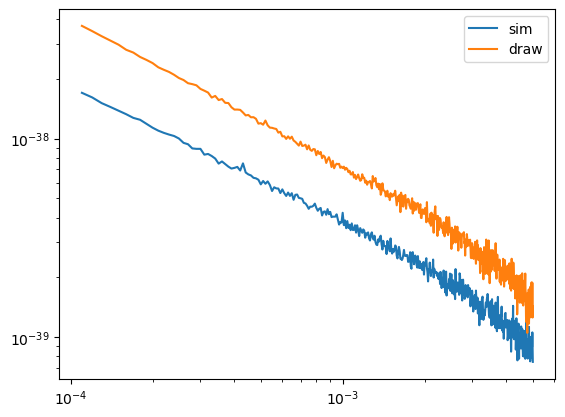

In [56]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(lowf_bins[1:],((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort[1:],label='sim')
# plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
plt.loglog(test_f, test_fg,label='draw')
# plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
#                                    *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:45<00:00,  8.27s/it]


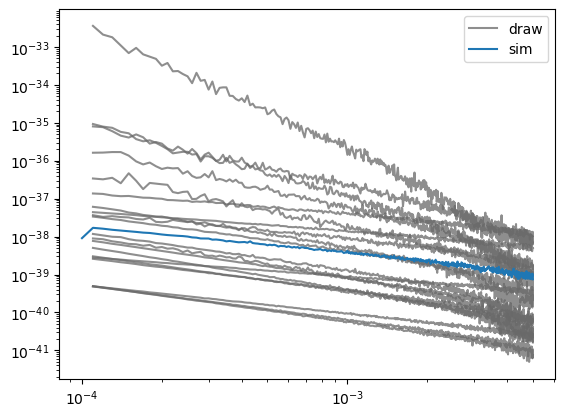

In [57]:
plt.figure()
for i in tqdm(range(20)):
    if i == 0:
        label='draw'
    else:
        label='__nolabel__'
    test_f, test_fg, _, _ = test_popmodel.run_model()
    plt.loglog(test_f, test_fg,label=label,c='dimgrey',alpha=0.75)
plt.loglog(lowf_bins,((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort,label='sim')
plt.legend()
plt.show()
    

Hell yeah. So now it's just a matter of building the per-bin foreground + N_res likelihood! This is a bit slow but has a LOT of optimizable bits; once we parallelize operations across frequency bins and port to GPU this will be blazing. (Honestly it's pretty fast for ten million binaries on CPU!)

In [58]:
tfgl = FG_Likelihood(((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort,0.1)

In [59]:
tfgl.ln_prob(0.1*((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort)

-2455.0

In [60]:
N_res

670

In [61]:
## built in the functions above
dataspec = ((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort[1:]
datadict = {'fg':dataspec,
            'fg_sigma':0.1, ## sigma_fg = 0.1 dex
            'Nres':N_res}

In [62]:
test_popmodel.construct_likelihood(datadict)

In [63]:
test_popmodel.Nsamp = 10

In [64]:
chain_out, fs, specs, Ns = test_popmodel.sample_likelihood(save_spec=True)

 30%|██████████████████████████████████████████▉                                                                                                    | 3/10 [00:26<01:01,  8.72s/it]/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.34s/it]


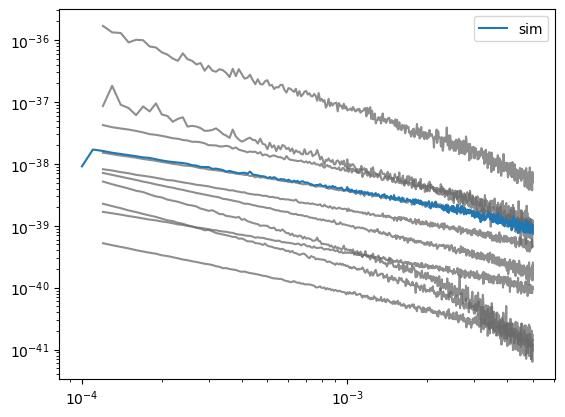

In [65]:
plt.figure()
for i in range(test_popmodel.Nsamp):
    plt.loglog(fs, specs[i],label=label,c='dimgrey',alpha=0.75)
plt.loglog(lowf_bins,((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort,label='sim')
plt.legend()
plt.show()

In [66]:
[L for L in chain_out[-1,:] if not np.isinf(L) ]

[-2632.842309924827,
 -436.7927677253059,
 -450.55430621629495,
 -1083.4913312907734,
 -7278.179877018729,
 -189.98325394368942]

In [67]:
L_mask = [True if not np.isinf(L) else False for L in chain_out[-1,:] ]

In [68]:
L_mask

[True, True, True, False, True, True, False, False, True, False]

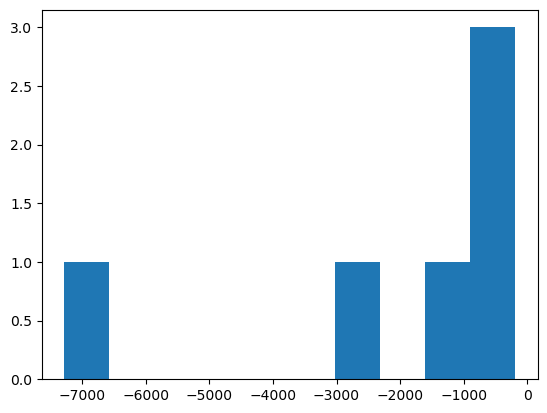

In [69]:
plt.figure()
plt.hist([L for L in chain_out[-1,:] if not np.isinf(L) ])
plt.show()

In [70]:
np.argmax(chain_out[-1,:])

8

In [71]:
chain_out[-1,:]

array([-2632.84230992,  -436.79276773,  -450.55430622,           -inf,
       -1083.49133129, -7278.17987702,           -inf,           -inf,
        -189.98325394,           -inf])

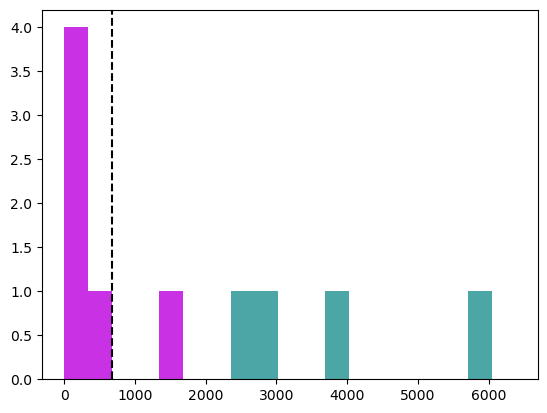

In [72]:
plt.figure()
bins = np.linspace(0,1.1*np.max(Ns),20)
plt.hist(Ns,bins=bins,color='teal',alpha=0.7,label='with infs')
plt.hist(np.array(Ns)[L_mask],bins=bins,color='magenta',alpha=0.7,label='without_infs')
plt.axvline(datadict['Nres'],ls='--',c='k',label='trueval')
plt.show()

In [73]:
Ns

[206, 219, 1360, 2714, 330, 573, 2355, 5798, 245, 3712]

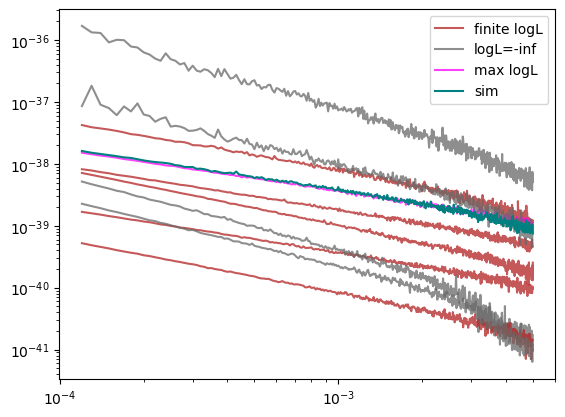

In [74]:
plt.figure()
finite_label_count = 0
inf_label_count = 0
for i in range(test_popmodel.Nsamp):
    if L_mask[i]:
        color='firebrick'
        if i==np.argmax(chain_out[-1,:]):
            color='magenta'
            label='max logL'
        else:
            if finite_label_count == 0:
                label='finite logL'
                finite_label_count +=1
            else:
                label='__nolabel__'
    else:
        color='dimgrey'
        if inf_label_count == 0:
            label='logL=-inf'
            inf_label_count +=1
        else:
            label='__nolabel__'
        
    plt.loglog(fs, specs[i],label=label,c=color,alpha=0.75)
plt.loglog(lowf_bins[2:],((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort[2:],label='sim',c='teal')
plt.legend()
plt.show()

In [75]:
np.mean(dataspec[2:])

2.6500490818208662e-39

In [76]:
[np.mean(spec) for spec in specs]

[2.696995887553586e-40,
 1.3180381917982043e-39,
 5.440470886561949e-39,
 3.120225155161415e-40,
 7.49157964167273e-40,
 5.932409699969555e-41,
 1.6229639944247628e-40,
 7.037851629407936e-38,
 2.6501103912378126e-39,
 7.584092897956764e-39]

In [77]:
L_mask

[True, True, True, False, True, True, False, False, True, False]

In [78]:
chain_out[-1,:]

array([-2632.84230992,  -436.79276773,  -450.55430622,           -inf,
       -1083.49133129, -7278.17987702,           -inf,           -inf,
        -189.98325394,           -inf])

In [79]:
Ns

[206, 219, 1360, 2714, 330, 573, 2355, 5798, 245, 3712]

Okay, cool. This is all making sense; the lowest (i.e., -inf) log likelihoods are those with extremely different numbers of resolved binaries, and the maximum is in fact the draw with the closest spectrum.

Now let's wrap this into Eryn...

In [80]:
## for now, blatantly copying from the Eryn tutorial
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds

In [159]:
ndim = len(test_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [160]:
translation_dict = {'0':'m_mu',
                    '1':'m_sigma',
                    '2':'d_gamma_a',
                    '3':'d_gamma_b',
                    '4':'a_alpha'}
## making these priors tighter to avoid initialization issues when testing eryn
eryn_hyperprior_dict = {0:st.norm(loc=0.6,scale=0.05),
                               1:st.invgamma(5),
                               2:st.uniform(loc=3,scale=2), ## these are pretty arbitrary
                               3:st.uniform(loc=3,scale=2), ## these are pretty arbitrary
                               4:st.uniform(0.25,0.75)
                              }

In [161]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [162]:
test_hprior = PopulationHyperPrior()

In [163]:
test_popmodel = PopModel(1e7,test_rng,fbins=lowf_bins)

In [164]:
## built in the functions above
dataspec = ((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort[1:]
datadict = {'fg':dataspec,
            'fg_sigma':0.1, ## sigma_fg = 0.1 dex
            'Nres':N_res}

In [165]:
test_popmodel.construct_likelihood(datadict)

In [166]:
log_like_fn = test_popmodel.fg_N_ln_prob

In [178]:
from multiprocessing import Pool

In [185]:
pool = Pool(nwalkers)

In [186]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_like_fn,
    eryn_prior,
    pool=pool
)
# ,
#     args=[means, invcov],
# )

In [171]:
for i in range(5):
    j = i
    while j<3:
        print(j)
        j += 1
print(j)

0
1
2
1
2
2
4


In [172]:
np.isinf(-np.inf)

True

In [173]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))

# check log_like, forcing the initialization to have finite log likelihood
log_like=np.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])
    while np.isinf(log_like[i]):
        coords[i] = eryn_prior.rvs(1)
        log_like[i] = log_like_fn(coords[i])
# log_like = np.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = np.asarray([
    eryn_prior.logpdf(coords[i])
for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

 10%|██████████████▎                                                                                                                                | 1/10 [00:08<01:15,  8.40s/it]/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.08s/it]

Log-likelihood:
 [ -382.35761343  -254.01330925   -70.6884784  -1082.54138846
  -295.24696805  -729.79140022  -178.63665387  -134.74841275
  -125.95189164   -84.17428801]

Log-prior:
 [1.82498836 0.87667847 2.49581555 1.69927817 2.32450346 1.74593719
 1.31334805 1.39718962 1.07677363 1.35223101]


In [187]:
nsteps = 100
# burn for 1000 steps
burn = 10
# thin by 1
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
pool.close()
pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [40:51<00:00, 24.51s/it]


In [188]:
# pool.terminate()

In [202]:
injdict = {'m_mu':np.array([0.6]),'m_sigma':np.array([0.15]),
             # 'd_mu':np.array([30]),'d_sigma':np.array([10]),
             'd_gamma_a':np.array([4]),'d_gamma_b':np.array([4]),
             'a_alpha':np.array([1/2])}
truths = np.array([injdict[key] for key in injdict.keys()]).flatten()

In [203]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

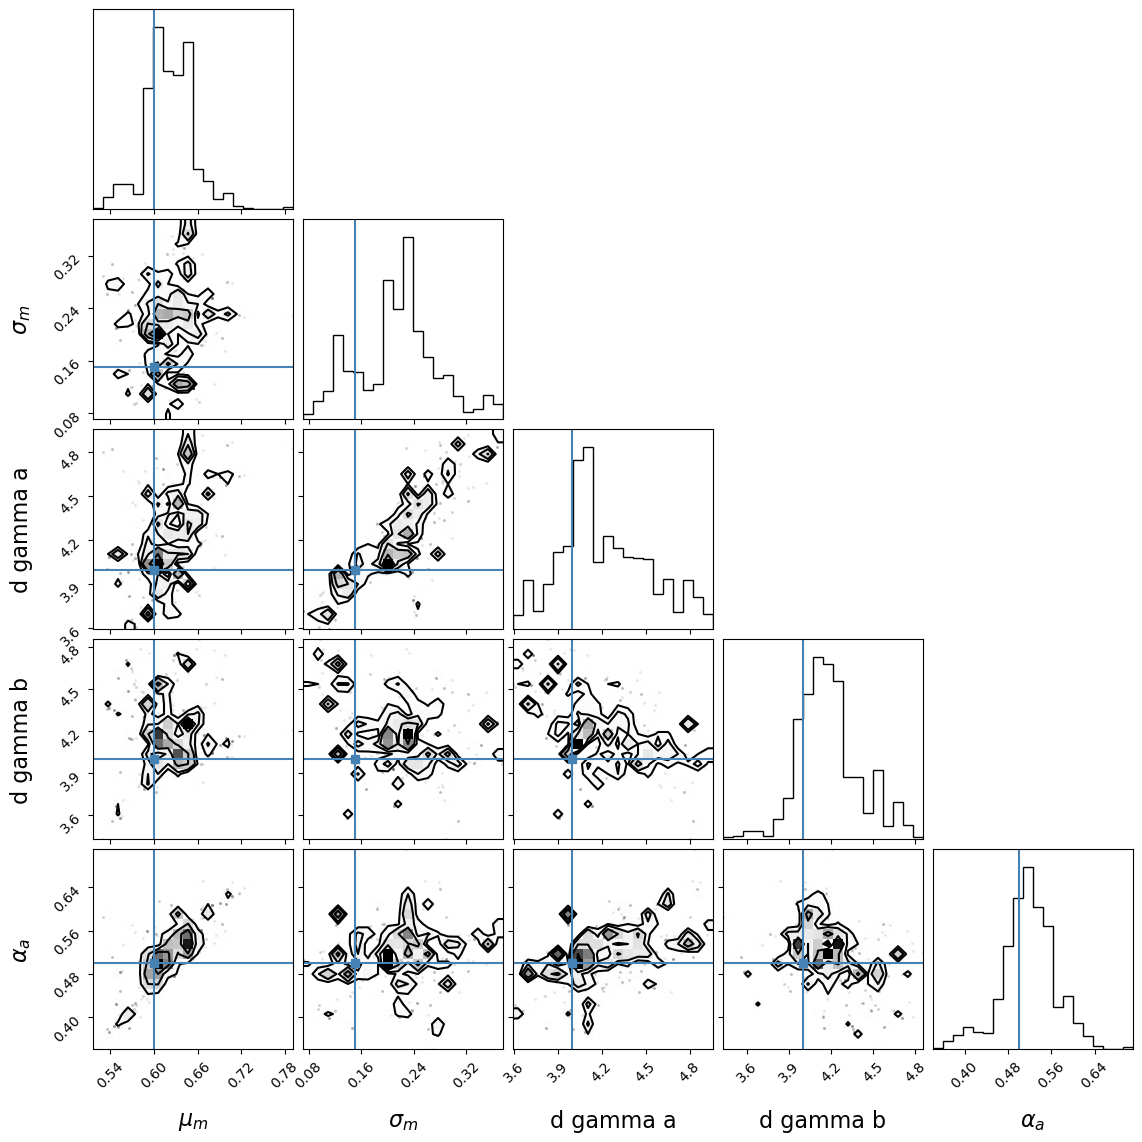

In [210]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
plt.savefig('first_initial_result.png',dpi=200)
plt.show()

In [242]:
means = np.mean(samples,axis=0)

In [243]:
means.shape

(5,)

In [244]:
means

array([0.62137554, 0.21451581, 4.22154571, 4.18333441, 0.51815632])

In [245]:
fs_mean, fg_mean, N_mean, _ = test_popmodel.run_model(means)

In [ ]:
## built in the functions above
dataspec = ((4*u.yr).to(u.s).value / bin_width**(-1))*fg_sort[1:]
datadict = {'fg':dataspec,
            'fg_sigma':0.1, ## sigma_fg = 0.1 dex
            'Nres':N_res}

In [247]:
print("Injected Nres: {}".format(datadict['Nres']))
print("Mean recovered Nres: {}".format(N_mean))

Injected Nres: 670
Mean recovered Nres: 705


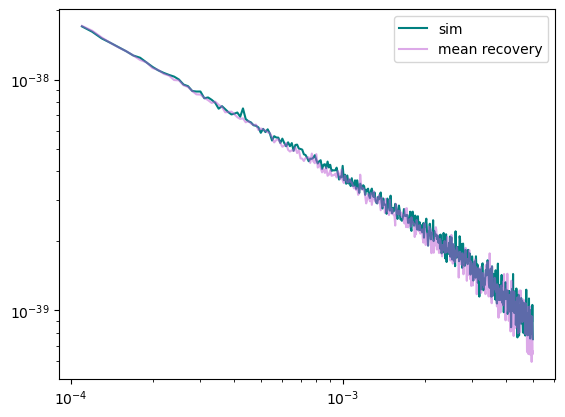

In [256]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(lowf_bins[1:],dataspec,label='sim',c='teal')
# plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
plt.loglog(fs_mean, fg_mean,alpha=0.5,label='mean recovery',c='mediumorchid')
# plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
#                                    *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.legend()
plt.show()

This is not correct, statistically. The right thing would be to recompute Nres and the spectrum for every sample, but I'm impatient and this should give a rough idea of the spread. (We should save Nres and the foreground spectra as latent variables in the chain as we go in the final implementation!)

In [252]:
## compute quantiles and their corresponding spectra/Nres
## VERY APPROXIMATE, NEGLECTS EFFECTS OF DEGENERACIES/INVERSE RELATIONSHIPS
lower95 = np.quantile(samples,0.025,axis=0)
upper95 = np.quantile(samples,0.975,axis=0)
print(lower95)
print(upper95)

[0.54729967 0.10471132 3.72901193 3.78789497 0.39954253]
[0.69337783 0.3473232  4.85074475 4.69188906 0.60867598]


In [253]:
fs_u95, fg_u95, N_u95, _ = test_popmodel.run_model(upper95)
fs_l95, fg_l95, N_l95, _ = test_popmodel.run_model(lower95)

In [255]:
print("Injected Nres: {}".format(datadict['Nres']))
print("Mean recovered Nres: {} (+{} / -{})".format(N_mean,N_l95-N_mean,N_mean-N_u95)) ## the fact that we have to flip this is representative of the problem!!|

Injected Nres: 670
Mean recovered Nres: 705 (+-103 / -30)


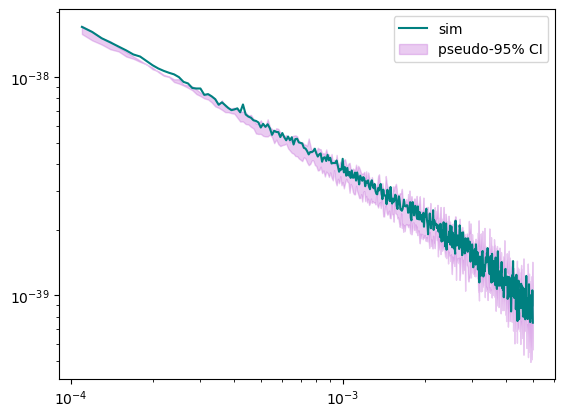

In [259]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(lowf_bins[1:],dataspec,label='sim',c='teal')
# plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
# plt.loglog(fs_mean, fg_mean,alpha=0.5,label='mean recovery')
plt.fill_between(fs_mean,fg_l95,fg_u95,alpha=0.3,label=r'pseudo-95% CI',color='mediumorchid')
# plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
#                                    *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.legend()
plt.show()

## RAD

and undersampled as hell but that's to be expected. But also let' make sure we're not prior-dominated here. Some of these are defnitely likelihood-informed ($\alpha_a$, the distance gamma parameters) but I'm less sure of the mass distribution since we put a Gaussian prior on it. Re-run with broader priors (and more samples)!

In [325]:
new_rng = np.random.default_rng(1001)

In [326]:
## broadening the priors, and switching the hyperprior for mu_m to uniform instead of normal
new_eryn_hyperprior_dict = {0:st.uniform(loc=0.4,scale=0.4),
                               1:st.invgamma(5),
                               2:st.uniform(loc=2.5,scale=3), ## these are pretty arbitrary
                               3:st.uniform(loc=2.5,scale=3), ## these are pretty arbitrary
                               4:st.uniform(0.25,0.75)
                              }

In [327]:
new_eryn_prior = ProbDistContainer(new_eryn_hyperprior_dict)

In [328]:
new_test_hprior = PopulationHyperPrior()

In [329]:
new_test_popmodel = PopModel(1e7,new_rng,fbins=lowf_bins)

In [330]:
ndim = len(new_test_popmodel.hyperprior.hyperprior_dict)
nwalkers = 16

In [331]:
new_test_popmodel.construct_likelihood(datadict)

In [332]:
new_log_like_fn = new_test_popmodel.fg_N_ln_prob

In [333]:
# pool.terminate()

In [334]:
pool = Pool(nwalkers)

/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
/tmp/ipykernel_10594/217220

In [335]:
new_ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    new_log_like_fn,
    new_eryn_prior,
    pool=pool
)
# ,
#     args=[means, invcov],
# )

In [336]:
# starting positions
# randomize throughout prior
new_coords = new_eryn_prior.rvs(size=(nwalkers,))

# check log_like, forcing the initialization to have finite log likelihood
new_log_like=np.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    new_log_like[i] = new_log_like_fn(new_coords[i])
    while np.isinf(new_log_like[i]):
        new_coords[i] = new_eryn_prior.rvs(1)
        new_log_like[i] = new_log_like_fn(new_coords[i])
# log_like = np.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", new_log_like)

# check log_prior
new_log_prior = np.asarray([
    new_eryn_prior.logpdf(new_coords[i])
for i in range(nwalkers)])
print("\nLog-prior:\n", new_log_prior)

  0%|                                                                                                                                                       | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_10594/2172205833.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(self.base_dist.pmf(N_res_theta))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:52<00:00, 10.77s/it]

Log-likelihood:
 [ -180.34930256 -2307.9841289   -917.41880091  -193.47199208
  -364.44135955  -124.45402271  -335.67650888   -11.48372561
 -1678.77740051  -263.21677536  -516.39543248  -624.30224668
 -1018.77378678 -2326.62726502   -31.93801291  -457.35193125]

Log-prior:
 [ 0.35335782  0.54040898  0.5630701   0.17167294  0.11959373  0.47020917
 -1.88427623  0.47874456  0.39211419 -1.92857042  0.47923369  0.54453022
  0.57567855 -2.65310485  0.26237391  0.47828942]


In [337]:
# new_ensemble.__dict__

Breaking this up into multiple steps because it keeps failing after burn-in due to a nonzero number of walkers having logL=-np.inf.

Actually scratch that, we've already assured proper initialization and can just discard the first N samples as burn-in. So skip the formal burn phase and just start sampling from the guaranteed finite start position.

In [338]:
# new_ensemble.reset()

In [339]:
nsteps = 1000
burn = None
thin_by = 1
out = new_ensemble.run_mcmc(new_coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
pool.close()
pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [8:28:28<00:00, 30.51s/it]


In [348]:
new_samples = new_ensemble.get_chain()['model_0']
print(new_samples.shape)
burned_samples = new_samples[300:,...]
print(burned_samples.shape)
thinned_samples = burned_samples[::2,...]
print(thinned_samples.shape)
thinned_samples = thinned_samples.reshape(-1,ndim)
print(thinned_samples.shape)

(1000, 1, 16, 1, 5)
(700, 1, 16, 1, 5)
(350, 1, 16, 1, 5)
(5600, 5)


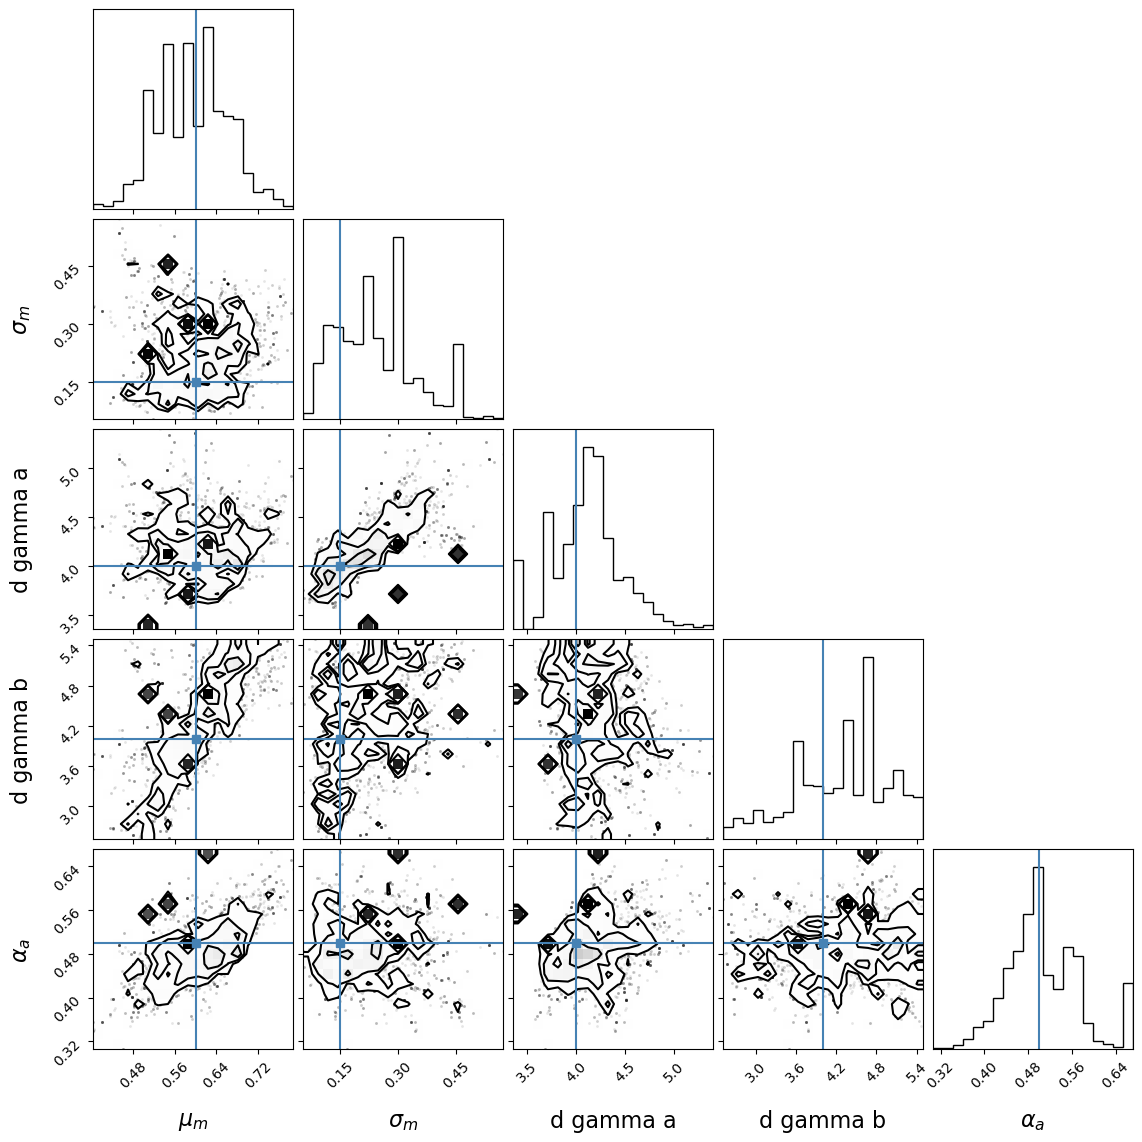

In [350]:
plt.rcParams.update({'axes.labelsize':16})


corner(thinned_samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
plt.savefig('broad_priors_initial_result.png',dpi=200)
plt.show()

Neat! Some immediate features of note:

- It looks like some of the chains are getting stuck on local maxima. Probably worth leveraging Eryn's parallel tempering here
- $\mu_m$ was definitely prior dominated before, but is now returning useful information.
- $\alpha_a$ is still well-recovered, as is the distance gamma a
- The distance gamma b is more or less unconstrained
- $\sigma_m$ looks to be prior dominated

In [351]:
new_means = np.mean(thinned_samples,axis=0)

In [352]:
new_fs_mean, new_fg_mean, new_N_mean, _ = test_popmodel.run_model(new_means)

In [353]:
print("Injected Nres: {}".format(datadict['Nres']))
print("Mean recovered Nres: {}".format(new_N_mean))

Injected Nres: 670
Mean recovered Nres: 779


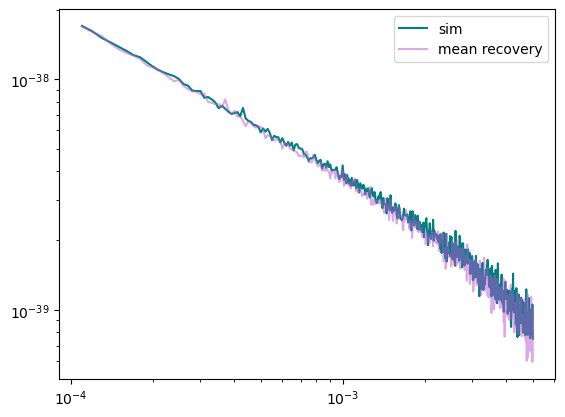

In [354]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(lowf_bins[1:],dataspec,label='sim',c='teal')
# plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
plt.loglog(new_fs_mean, new_fg_mean,alpha=0.5,label='mean recovery',c='mediumorchid')
# plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
#                                    *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.legend()
plt.show()

This is not correct, statistically. The right thing would be to recompute Nres and the spectrum for every sample, but I'm impatient and this should give a rough idea of the spread. (We should save Nres and the foreground spectra as latent variables in the chain as we go in the final implementation!)

In [355]:
## compute quantiles and their corresponding spectra/Nres
## VERY APPROXIMATE, NEGLECTS EFFECTS OF DEGENERACIES/INVERSE RELATIONSHIPS
new_lower95 = np.quantile(thinned_samples,0.025,axis=0)
new_upper95 = np.quantile(thinned_samples,0.975,axis=0)
print(lower95)
print(upper95)

[0.54729967 0.10471132 3.72901193 3.78789497 0.39954253]
[0.69337783 0.3473232  4.85074475 4.69188906 0.60867598]


In [356]:
new_fs_u95, new_fg_u95, new_N_u95, _ = test_popmodel.run_model(new_upper95)
new_fs_l95, new_fg_l95, new_N_l95, _ = test_popmodel.run_model(new_lower95)

In [357]:
print("Injected Nres: {}".format(datadict['Nres']))
print("Mean recovered Nres: {} (+{} / -{})".format(new_N_mean,new_N_l95-new_N_mean,new_N_mean-new_N_u95)) ## the fact that we have to flip this is representative of the problem!!|

Injected Nres: 670
Mean recovered Nres: 779 (+152 / --63)


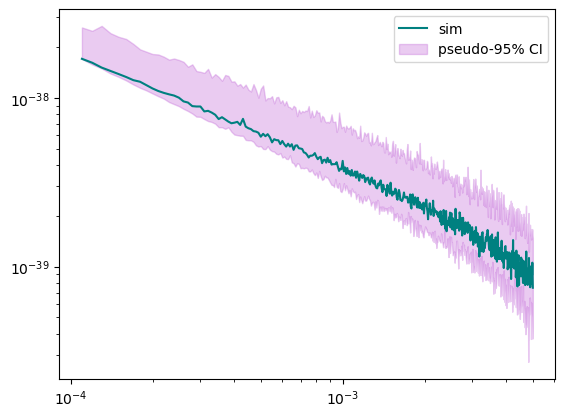

In [358]:
plt.figure()
# plt.loglog(fbins_test,np.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(lowf_bins[1:],dataspec,label='sim',c='teal')
# plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
# plt.loglog(fs_mean, fg_mean,alpha=0.5,label='mean recovery')
plt.fill_between(new_fs_mean,new_fg_l95,new_fg_u95,alpha=0.3,label=r'pseudo-95% CI',color='mediumorchid')
# plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
#                                    *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.legend()
plt.show()

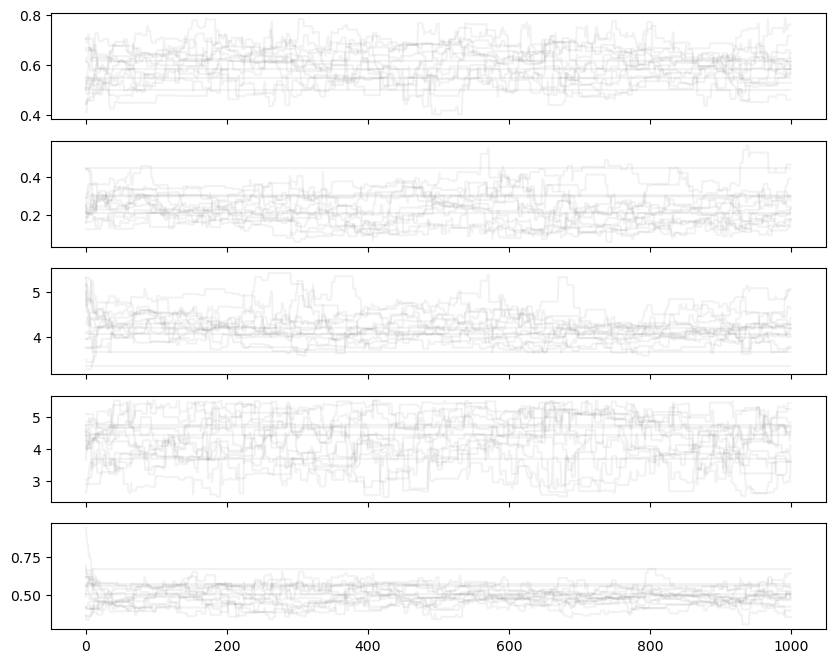

In [359]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(new_ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.05)

Yep, we can even visually see the problem chains which get stuck in certain parts of the parameter space. PT ho!